In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *

In [4]:
path = untar_data(URLs.MNIST)

In [6]:
path.ls()

[PosixPath('/home/vishaladu/.fastai/data/mnist_png/testing'),
 PosixPath('/home/vishaladu/.fastai/data/mnist_png/training')]

In [7]:
# Creating an image list from folder
il = ImageList.from_folder(path, convert_mode='L')

In [8]:
il.items[0] #all paths are under items

PosixPath('/home/vishaladu/.fastai/data/mnist_png/testing/3/6504.png')

In [9]:
#change color map to binary
defaults.cmap = 'binary' 

In [10]:
#each image is 28, 28 pixels
#there is a unit axis (1, 28, 28) because it is easier
#to use the existing stuff with a Rank 3 tensor
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/vishaladu/.fastai/data/mnist_png

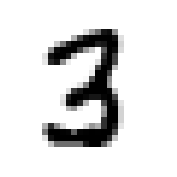

In [11]:
il[0].show()

In [12]:
#creating train and valid sets based on folders
sd = il.split_by_folder(train='training', valid='testing')

In [13]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/vishaladu/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/vishaladu/.fastai/data/mnist_png;

Test: None

In [15]:
#creates a label list by labelling the data
#using folder name
ll = sd.label_from_folder()

In [27]:
#returns the image and the category it belongs to
x,y = ll.train[0]

3 torch.Size([1, 28, 28])


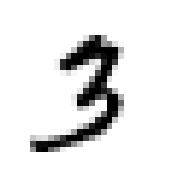

In [24]:
x.show()
print(y, x.shape)

In [28]:
#creates a set of transforms
#here, I create padding with size of 3 and fill it with 0
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [30]:
#add tfms to ll
ll.transform(tfms)

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /home/vishaladu/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /home/vishaladu/.fastai/data/mnist_png;

Test: None

In [31]:
bs = 128

In [32]:
# not using image_net stats to normalize because we will not
# be using pretraining
data = ll.databunch(bs=bs).normalize()

In [33]:
#grab first item from training dataset
x,y = data.train_ds[0]

3


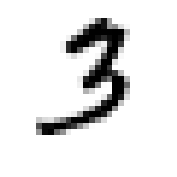

In [34]:
#check out data
x.show()
print(y)

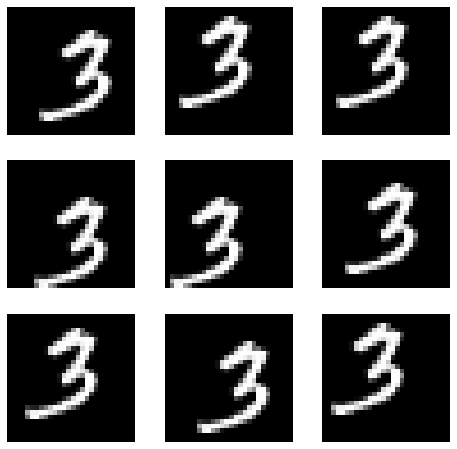

In [35]:
#create aplot function to better viz data
def _plot(i, j, ax): data.train_ds[0][0].show(ax, cmap='gray')

plot_multi(_plot, 3, 3, figsize=(8,8))

In [37]:
#get one mini batch
#the shape is [128, 1, 28, 28] for xb because this is
#one batch (bs=128) of the images which are [1, 28, 28]
#yb is [128] because it has a category for each image
xb, yb = data.one_batch()
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

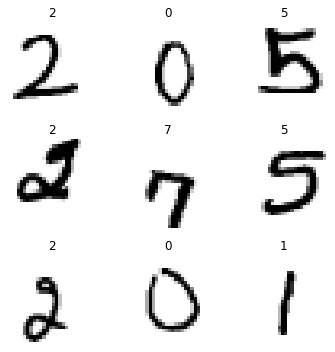

In [38]:
data.show_batch(rows=3, figsize=(5,5))

### Basic NN with batchnorm

In [40]:
#create a conv function
def conv(ni, nf):
    ''' This function returns a conv with ni input channels and nf
        output channels. The kernel size used is 3x3, while skipping 
        2 pixels at a time. The matrix is also padded with a 
        1 pixel border.
    '''
    return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [41]:
#create a basic nn model
model = nn.Sequential(
    conv(1,8 ), #14x14 -> because of conv, the size is halved
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), #7x7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), #4x4 -> math.ceiling of size/2
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), #2x2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), #1x1
    nn.BatchNorm2d(10),
    Flatten() #removes the (1,1) grid
)

In [47]:
#create a learner obj
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), 
                metrics=accuracy)

In [50]:
#summarize model
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [52]:
#Add the batch to gpu
xb = xb.cuda()

In [53]:
#run the batch through model
model(xb).shape

torch.Size([128, 10])

In [54]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


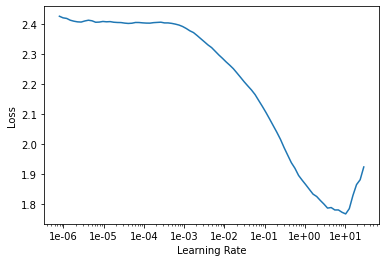

In [55]:
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.232878,0.202743,0.935400,00:03
1,0.127579,0.081718,0.974700,00:03
2,0.079079,0.044373,0.986400,00:03


### Refactor

In [57]:
#use conv_layer instead of writting conv, bn, relu multiple times
def conv2(ni, nf): return conv_layer(ni, nf, stride=2)

In [58]:
model = nn.Sequential(
    conv2(1, 8), #14
    conv2(8, 16), #7
    conv2(16, 32), #4
    conv2(32, 16), #2
    conv2(16, 10), #1
    Flatten() # remove(1,1) grid
)

In [59]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), 
               metrics=accuracy)

In [60]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.240346,0.192651,0.937600,00:03
1,0.190802,0.167527,0.946400,00:03
2,0.167410,0.189099,0.939200,00:03
3,0.131436,0.080264,0.975200,00:03
4,0.113042,0.091946,0.970600,00:03
5,0.103798,0.058639,0.982400,00:03
6,0.080151,0.047657,0.983800,00:03
7,0.063303,0.040812,0.986400,00:03
8,0.043926,0.027990,0.991800,00:03
9,0.040500,0.026282,0.991700,00:03


### Resnet-ish

In [62]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf, nf)
        self.conv2 = conv_layer(nf, nf)
        
    def forward(self, x): 
        return x + self.conv2(self.conv1(x))

In [64]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv(16, 10),
    Flatten()
)

In [65]:
# refactor the code above
def conv_and_res(ni, nf): 
    return nn.Sequential(conv2(ni, nf), res_block(nf))

In [66]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [68]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), 
                metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


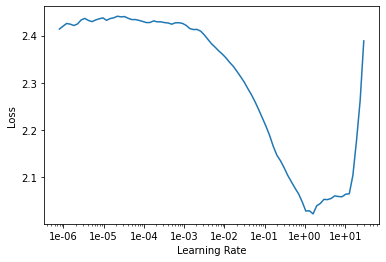

In [69]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [70]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.232040,0.137927,0.961100,00:06
1,0.129164,0.699240,0.787100,00:05
2,0.105537,0.122520,0.962100,00:06
3,0.084951,0.073862,0.977300,00:06
4,0.069779,0.058857,0.982200,00:06
5,0.060492,0.057781,0.980800,00:06
6,0.053409,0.054427,0.983400,00:06
7,0.047379,0.034046,0.988900,00:06
8,0.040376,0.026464,0.992100,00:06
9,0.028792,0.018892,0.994000,00:06


In [71]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________